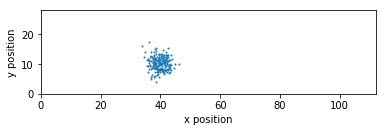

46.155454807288905
17.222309967935953


In [1]:
import pandas as pd
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import make_random_selfdata
from PIL import Image, ImageDraw
import train_myrcvae
import net
import chainer
from chainer import serializers
%matplotlib inline

In [2]:
def read_csv(csv_file):
    df = pd.read_csv(csv_file, sep=',', header=None)
    len_cols = len(df)
    image_name = df.loc[0:len_cols,3]
    x = np.array(df.loc[0:len_cols,0], np.float32)
    y = np.array(df.loc[0:len_cols,1], np.float32)
    th = np.array(df.loc[0:len_cols,2], np.float32)
    return image_name, x, y, th
def separetePosition_and_angle_probabilityMap(data, data_len, border):
    angle_map_l = len(data[0]) - border 
    pos_map = np.zeros((data_len, border), dtype=np.float32)
    angle_map = np.zeros((data_len, angle_map_l), dtype=np.float32)
    for n in range(data_len):
        pos_map[n,:] = data[n][0:border]
        angle_map[n,:] = data[n][border:]
    return pos_map, angle_map

In [3]:
class Plot:
    def __init__(self, make_random_selfdata_cls):
        self.disp_image_ratio = 150
        self.pred_pos_map_ratio = 150
        self.field_w = make_random_selfdata_cls.field_w
        self.field_h = make_random_selfdata_cls.field_h
        self.vrep_onehot_w = make_random_selfdata_cls.vrep_onehot_w
        self.vrep_onehot_h = make_random_selfdata_cls.vrep_onehot_h
        self.field_img = Image.open("hukan.png")
        self.r = 2
        self.robot_color = "black"
        self.field_mergin = 5

    def plotRobot(self, x, y, th, ax):
        xn = x + self.r * math.cos(th)
        yn = y + self.r * math.sin(th)
        ax.plot([x, xn], [y, yn], color="black", linewidth=2)
        c = patch.Circle(xy=(x, y), radius=self.r, fill=False, color="black", linewidth=2)
        ax.add_patch(c)
    def plotParticle(self, particles, ax): # x, y, th, weight
        weights = [p.weight for p in particles]
        col_map = [p.weight for p in particles]
        wmax = np.max(weights)
        wmin = np.min(weights)
        if(wmax == wmin):
            norm_w = [p.weight for p in particles] -wmax
        else:
            norm_w = [((w - wmin) / (wmax - wmin)) for w in weights]
        xs = [p.pose[0]+self.field_mergin for p in particles]
        ys = [p.pose[1]+self.field_mergin for p in particles]
        vxs = [math.cos(particles[i].pose[2])*norm_w[i]*len(particles) for i in range(len(particles))] #重みを要素に反映
        vys = [math.sin(particles[i].pose[2])*norm_w[i]*len(particles) for i in range(len(particles))]  #重みを要素に反映
        q = ax.quiver(xs, ys, vxs, vys, norm_w, angles='xy', scale_units='xy', scale=0.5, alpha=0.9) #変更
        cb = fig.colorbar(q)
        cb.set_clim()
    def plotUpdate(self, x, y, th, particle, ax):
        self.plotRobot(x+self.field_mergin, y+self.field_mergin, th,ax)
        self.plotParticle(particle, ax)
        ax.imshow(self.field_img)
        plt.show()
    def convertVrepPos2DisplayPosValue(self, x, y): # Vrep の座標系から，表示のために倍率を変えてる
        f_w = self.field_w
        f_h = self.field_h
        x = (x + f_w/2)/self.disp_image_ratio #+ self.field_mergin
        y = int(self.field_h/self.disp_image_ratio) - (y + f_h/2)/self.disp_image_ratio# + self.field_mergin
        return x, y

In [16]:
class Particle():
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight
    def motion_update(self, x, y, th, pre_x, pre_y, pre_th):
        #適当なランダムを加えながらモーションアップデートする（真値の1番目ー0番目）
        x, y = plot_cls.convertVrepPos2DisplayPosValue(x, y)
        pre_x, pre_y = plot_cls.convertVrepPos2DisplayPosValue(pre_x, pre_y)
        px = x - pre_x + np.random.normal(-0.1, 0.1 , 1)[0]
        py = y - pre_y + np.random.normal(-0.1, 0.1, 1)[0]
        pth = th - pre_th
        dx =  self.pose[0] + px 
        dy = self.pose[1] + py 
        dth = self.pose[2] + pth
        return [dx, dy, dth]
    def observation_update(self, pos_map, angle_map):
        m_x, m_y = self.getPosMapXY_fromParticlePos()
        m_x = int(m_x)
        m_y = int(m_y)
        angle_map_x, angle_map_y = self.getAngleMapXY_fromParticleThera()
        alpha = 0.6
        print(angle_map_y, angle_map_x, "angle_map y, x")
        print(angle_map[angle_map_y, angle_map_x], "angle map weight")
        self.weight = alpha*self.weight + (1-alpha)*(pos_map[m_y,m_x] + angle_map[angle_map_y, angle_map_x])
    def getPosMapXY_fromParticlePos(self):
        return int(self.pose[0]+ plot_cls.field_mergin), int(self.pose[1]+ plot_cls.field_mergin)
    def getAngleMapXY_fromParticleThera(self):
        x = int(39*np.cos(self.pose[2])+40)
        y = int(39*np.sin(self.pose[2]))
        return int(x), int(y)

In [5]:
class Robot:
    def __init__(self, init_x, init_y, init_theta):
        self.init_x = init_x
        self.init_y = init_y
        self.init_theta = init_theta
    def motion_update(self, x, y, th):
        #csv から位置を更新
        rx, ry = plot_cls.convertVrepPos2DisplayPosValue(x, y)
        return rx, ry, th
    def observation_update():
        pass

In [6]:
class CVAE:
    def __init__(self):
        self.NLABELDIM = 1200
        self.CONTEXTDIM = 5701
        self.NZDIM = 1
        self.HIDDEN = 1200
        self.z = chainer.Variable(np.zeros((1, 1), dtype=np.float32))
        self.model = net.MyCVAE(self.CONTEXTDIM, self.NZDIM, self.HIDDEN, self.NLABELDIM)
        serializers.load_npz("mymodel_final.npz", self.model)
        self.pos_map = np.zeros((plot_cls.vrep_onehot_w*plot_cls.vrep_onehot_h), dtype=np.float32)
        self.angle_map = np.zeros((40*80), dtype=np.float32)
    def pred_CVAE(self, image_name):
        value = np.zeros((1, 40*30), dtype=np.float32)
        img = np.ravel(Image.open(image_name))
        img = img.astype(np.float32)
        with chainer.using_config('train', False), chainer.no_backprop_mode():
            x = self.model.decode(self.z, np.expand_dims(img, axis=0))
        self.pos_map, self.angle_map = separetePosition_and_angle_probabilityMap(x.data, len(x.data), plot_cls.vrep_onehot_w* plot_cls.vrep_onehot_h)
    def getMaps(self):
        pos_map_mat = np.reshape(self.pos_map, (plot_cls.vrep_onehot_h, plot_cls.vrep_onehot_w))
        angle_map_mat = np.reshape(self.angle_map,(40,80))
        return pos_map_mat, angle_map_mat
    def dammyGetMaps(self):
        pos_map_mat = np.reshape(self.pos_map, (plot_cls.vrep_onehot_h, plot_cls.vrep_onehot_w))
        pos_map_mat = cv2.imread("dammy_pos_map.jpg", -1)
        angle_map_mat = np.reshape(self.angle_map,(40,80))
        return pos_map_mat, angle_map_mat

In [7]:
def returnKidoAxisFropmPosMap(pos_map):
    kido = np.empty((0,2), dtype=np.float32)
    for h in range(pos_map.shape[0]):
        for w in range(pos_map.shape[1]):
            if(pos_map[h, w] > 0):
                kido = np.append(kido, np.array([[w,h]]), axis=0)
    return kido

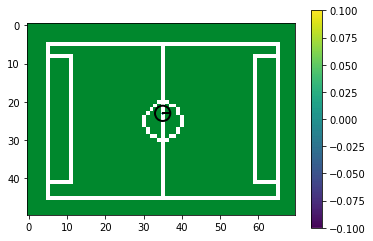

0 79 angle_map y, x
0.43894336 angle map weight
0 79 angle_map y, x
0.43894336 angle map weight
0 79 angle_map y, x
0.43894336 angle map weight
0 79 angle_map y, x
0.43894336 angle map weight
0 79 angle_map y, x
0.43894336 angle map weight
0 79 angle_map y, x
0.43894336 angle map weight
0 79 angle_map y, x
0.43894336 angle map weight
0 79 angle_map y, x
0.43894336 angle map weight
0 79 angle_map y, x
0.43894336 angle map weight
0 79 angle_map y, x
0.43894336 angle map weight


<Figure size 432x288 with 0 Axes>

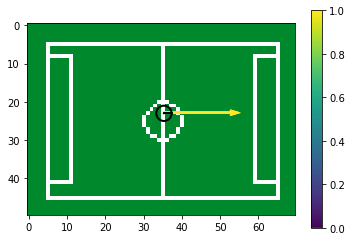

0 79 angle_map y, x
0.0764066 angle map weight
0 79 angle_map y, x
0.0764066 angle map weight
0 79 angle_map y, x
0.0764066 angle map weight
0 79 angle_map y, x
0.0764066 angle map weight
0 79 angle_map y, x
0.0764066 angle map weight
0 79 angle_map y, x
0.0764066 angle map weight
0 79 angle_map y, x
0.0764066 angle map weight
0 79 angle_map y, x
0.0764066 angle map weight
0 79 angle_map y, x
0.0764066 angle map weight
0 79 angle_map y, x
0.0764066 angle map weight


<Figure size 432x288 with 0 Axes>

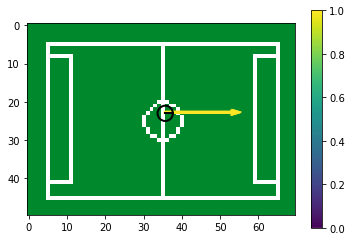

0 79 angle_map y, x
0.48256797 angle map weight
0 79 angle_map y, x
0.48256797 angle map weight
0 79 angle_map y, x
0.48256797 angle map weight
0 79 angle_map y, x
0.48256797 angle map weight
0 79 angle_map y, x
0.48256797 angle map weight
0 79 angle_map y, x
0.48256797 angle map weight
0 79 angle_map y, x
0.48256797 angle map weight
0 79 angle_map y, x
0.48256797 angle map weight
0 79 angle_map y, x
0.48256797 angle map weight
0 79 angle_map y, x
0.48256797 angle map weight


<Figure size 432x288 with 0 Axes>

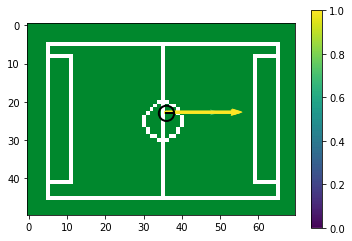

0 79 angle_map y, x
0.20027626 angle map weight
0 79 angle_map y, x
0.20027626 angle map weight
0 79 angle_map y, x
0.20027626 angle map weight
0 79 angle_map y, x
0.20027626 angle map weight
0 79 angle_map y, x
0.20027626 angle map weight
0 79 angle_map y, x
0.20027626 angle map weight
0 79 angle_map y, x
0.20027626 angle map weight
0 79 angle_map y, x
0.20027626 angle map weight
0 79 angle_map y, x
0.20027626 angle map weight
0 79 angle_map y, x
0.20027626 angle map weight


<Figure size 432x288 with 0 Axes>

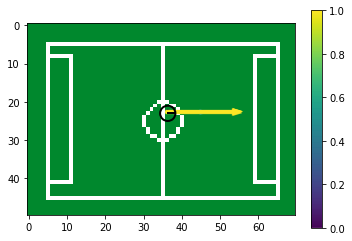

0 79 angle_map y, x
0.29287076 angle map weight
0 79 angle_map y, x
0.29287076 angle map weight
0 79 angle_map y, x
0.29287076 angle map weight
0 79 angle_map y, x
0.29287076 angle map weight
0 79 angle_map y, x
0.29287076 angle map weight
0 79 angle_map y, x
0.29287076 angle map weight
0 79 angle_map y, x
0.29287076 angle map weight
0 79 angle_map y, x
0.29287076 angle map weight
0 79 angle_map y, x
0.29287076 angle map weight
0 79 angle_map y, x
0.29287076 angle map weight


<Figure size 432x288 with 0 Axes>

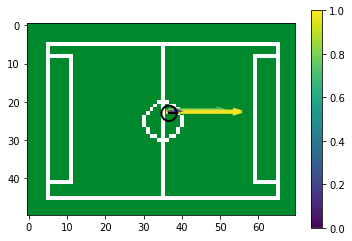

0 79 angle_map y, x
0.18285874 angle map weight
0 79 angle_map y, x
0.18285874 angle map weight
0 79 angle_map y, x
0.18285874 angle map weight
0 79 angle_map y, x
0.18285874 angle map weight
0 79 angle_map y, x
0.18285874 angle map weight
0 79 angle_map y, x
0.18285874 angle map weight
0 79 angle_map y, x
0.18285874 angle map weight
0 79 angle_map y, x
0.18285874 angle map weight
0 79 angle_map y, x
0.18285874 angle map weight
0 79 angle_map y, x
0.18285874 angle map weight


<Figure size 432x288 with 0 Axes>

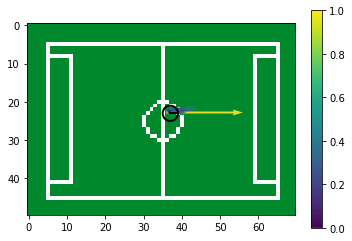

0 79 angle_map y, x
0.11284399 angle map weight
0 79 angle_map y, x
0.11284399 angle map weight
0 79 angle_map y, x
0.11284399 angle map weight
0 79 angle_map y, x
0.11284399 angle map weight
0 79 angle_map y, x
0.11284399 angle map weight
0 79 angle_map y, x
0.11284399 angle map weight
0 79 angle_map y, x
0.11284399 angle map weight
0 79 angle_map y, x
0.11284399 angle map weight
0 79 angle_map y, x
0.11284399 angle map weight
0 79 angle_map y, x
0.11284399 angle map weight


<Figure size 432x288 with 0 Axes>

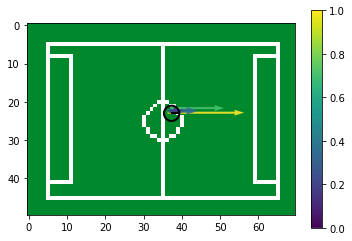

0 79 angle_map y, x
0.26654023 angle map weight
0 79 angle_map y, x
0.26654023 angle map weight
0 79 angle_map y, x
0.26654023 angle map weight
0 79 angle_map y, x
0.26654023 angle map weight
0 79 angle_map y, x
0.26654023 angle map weight
0 79 angle_map y, x
0.26654023 angle map weight
0 79 angle_map y, x
0.26654023 angle map weight
0 79 angle_map y, x
0.26654023 angle map weight
0 79 angle_map y, x
0.26654023 angle map weight
0 79 angle_map y, x
0.26654023 angle map weight


<Figure size 432x288 with 0 Axes>

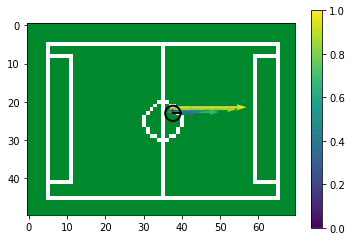

0 79 angle_map y, x
0.024024814 angle map weight
0 79 angle_map y, x
0.024024814 angle map weight
0 79 angle_map y, x
0.024024814 angle map weight
0 79 angle_map y, x
0.024024814 angle map weight
0 79 angle_map y, x
0.024024814 angle map weight
0 79 angle_map y, x
0.024024814 angle map weight
0 79 angle_map y, x
0.024024814 angle map weight
0 79 angle_map y, x
0.024024814 angle map weight
0 79 angle_map y, x
0.024024814 angle map weight
0 79 angle_map y, x
0.024024814 angle map weight


<Figure size 432x288 with 0 Axes>

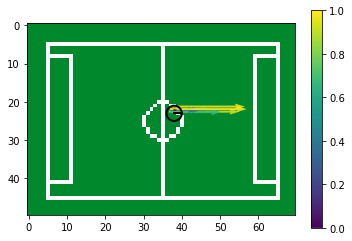

0 79 angle_map y, x
0.1607615 angle map weight
0 79 angle_map y, x
0.1607615 angle map weight
0 79 angle_map y, x
0.1607615 angle map weight
0 79 angle_map y, x
0.1607615 angle map weight
0 79 angle_map y, x
0.1607615 angle map weight
0 79 angle_map y, x
0.1607615 angle map weight
0 79 angle_map y, x
0.1607615 angle map weight
0 79 angle_map y, x
0.1607615 angle map weight
0 79 angle_map y, x
0.1607615 angle map weight
0 79 angle_map y, x
0.1607615 angle map weight


<Figure size 432x288 with 0 Axes>

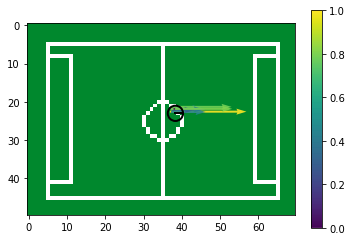

0 79 angle_map y, x
0.24483502 angle map weight
0 79 angle_map y, x
0.24483502 angle map weight
0 79 angle_map y, x
0.24483502 angle map weight
0 79 angle_map y, x
0.24483502 angle map weight
0 79 angle_map y, x
0.24483502 angle map weight
0 79 angle_map y, x
0.24483502 angle map weight
0 79 angle_map y, x
0.24483502 angle map weight
0 79 angle_map y, x
0.24483502 angle map weight
0 79 angle_map y, x
0.24483502 angle map weight
0 79 angle_map y, x
0.24483502 angle map weight


<Figure size 432x288 with 0 Axes>

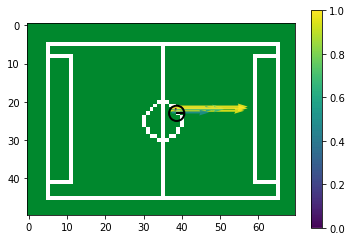

0 79 angle_map y, x
0.30457193 angle map weight
0 79 angle_map y, x
0.30457193 angle map weight
0 79 angle_map y, x
0.30457193 angle map weight
0 79 angle_map y, x
0.30457193 angle map weight
0 79 angle_map y, x
0.30457193 angle map weight
0 79 angle_map y, x
0.30457193 angle map weight
0 79 angle_map y, x
0.30457193 angle map weight
0 79 angle_map y, x
0.30457193 angle map weight
0 79 angle_map y, x
0.30457193 angle map weight
0 79 angle_map y, x
0.30457193 angle map weight


<Figure size 432x288 with 0 Axes>

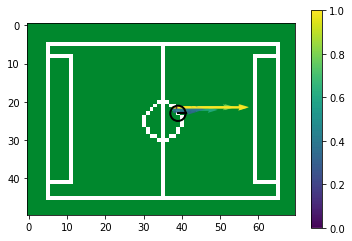

0 79 angle_map y, x
0.48073834 angle map weight
0 79 angle_map y, x
0.48073834 angle map weight
0 79 angle_map y, x
0.48073834 angle map weight
0 79 angle_map y, x
0.48073834 angle map weight
0 79 angle_map y, x
0.48073834 angle map weight
0 79 angle_map y, x
0.48073834 angle map weight
0 79 angle_map y, x
0.48073834 angle map weight
0 79 angle_map y, x
0.48073834 angle map weight
0 79 angle_map y, x
0.48073834 angle map weight
0 79 angle_map y, x
0.48073834 angle map weight


<Figure size 432x288 with 0 Axes>

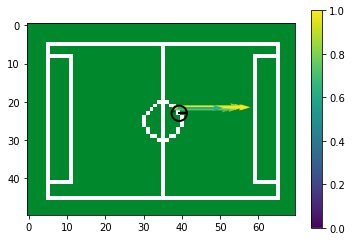

0 79 angle_map y, x
0.8124192 angle map weight
0 79 angle_map y, x
0.8124192 angle map weight
0 79 angle_map y, x
0.8124192 angle map weight
0 79 angle_map y, x
0.8124192 angle map weight
0 79 angle_map y, x
0.8124192 angle map weight
0 79 angle_map y, x
0.8124192 angle map weight
0 79 angle_map y, x
0.8124192 angle map weight
0 79 angle_map y, x
0.8124192 angle map weight
0 79 angle_map y, x
0.8124192 angle map weight
0 79 angle_map y, x
0.8124192 angle map weight


<Figure size 432x288 with 0 Axes>

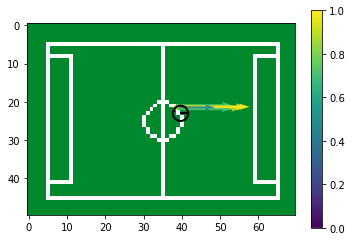

0 79 angle_map y, x
0.73315686 angle map weight
0 79 angle_map y, x
0.73315686 angle map weight
0 79 angle_map y, x
0.73315686 angle map weight
0 79 angle_map y, x
0.73315686 angle map weight
0 79 angle_map y, x
0.73315686 angle map weight
0 79 angle_map y, x
0.73315686 angle map weight
0 79 angle_map y, x
0.73315686 angle map weight
0 79 angle_map y, x
0.73315686 angle map weight
0 79 angle_map y, x
0.73315686 angle map weight
0 79 angle_map y, x
0.73315686 angle map weight


<Figure size 432x288 with 0 Axes>

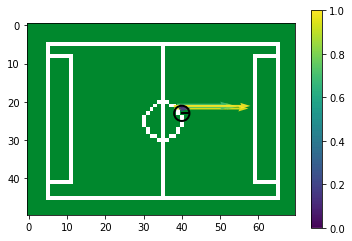

0 79 angle_map y, x
0.18609864 angle map weight
0 79 angle_map y, x
0.18609864 angle map weight
0 79 angle_map y, x
0.18609864 angle map weight
0 79 angle_map y, x
0.18609864 angle map weight
0 79 angle_map y, x
0.18609864 angle map weight
0 79 angle_map y, x
0.18609864 angle map weight
0 79 angle_map y, x
0.18609864 angle map weight
0 79 angle_map y, x
0.18609864 angle map weight
0 79 angle_map y, x
0.18609864 angle map weight
0 79 angle_map y, x
0.18609864 angle map weight


<Figure size 432x288 with 0 Axes>

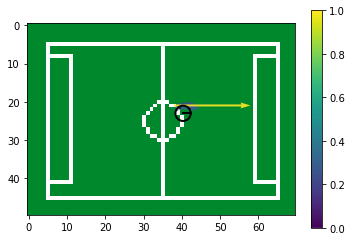

0 79 angle_map y, x
0.3266223 angle map weight
0 79 angle_map y, x
0.3266223 angle map weight
0 79 angle_map y, x
0.3266223 angle map weight
0 79 angle_map y, x
0.3266223 angle map weight
0 79 angle_map y, x
0.3266223 angle map weight
0 79 angle_map y, x
0.3266223 angle map weight
0 79 angle_map y, x
0.3266223 angle map weight
0 79 angle_map y, x
0.3266223 angle map weight
0 79 angle_map y, x
0.3266223 angle map weight
0 79 angle_map y, x
0.3266223 angle map weight


<Figure size 432x288 with 0 Axes>

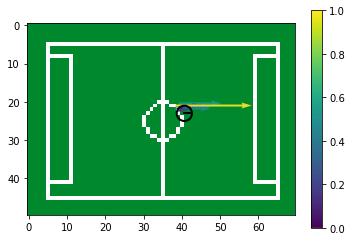

0 79 angle_map y, x
0.36802 angle map weight
0 79 angle_map y, x
0.36802 angle map weight
0 79 angle_map y, x
0.36802 angle map weight
0 79 angle_map y, x
0.36802 angle map weight
0 79 angle_map y, x
0.36802 angle map weight
0 79 angle_map y, x
0.36802 angle map weight
0 79 angle_map y, x
0.36802 angle map weight
0 79 angle_map y, x
0.36802 angle map weight
0 79 angle_map y, x
0.36802 angle map weight
0 79 angle_map y, x
0.36802 angle map weight


<Figure size 432x288 with 0 Axes>

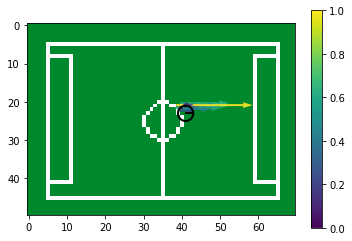

0 79 angle_map y, x
0.9068401 angle map weight
0 79 angle_map y, x
0.9068401 angle map weight
0 79 angle_map y, x
0.9068401 angle map weight
0 79 angle_map y, x
0.9068401 angle map weight
0 79 angle_map y, x
0.9068401 angle map weight
0 79 angle_map y, x
0.9068401 angle map weight
0 79 angle_map y, x
0.9068401 angle map weight
0 79 angle_map y, x
0.9068401 angle map weight
0 79 angle_map y, x
0.9068401 angle map weight
0 79 angle_map y, x
0.9068401 angle map weight


<Figure size 432x288 with 0 Axes>

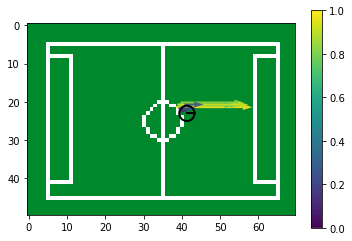

0 79 angle_map y, x
0.7341691 angle map weight
0 79 angle_map y, x
0.7341691 angle map weight
0 79 angle_map y, x
0.7341691 angle map weight
0 79 angle_map y, x
0.7341691 angle map weight
0 79 angle_map y, x
0.7341691 angle map weight
0 79 angle_map y, x
0.7341691 angle map weight
0 79 angle_map y, x
0.7341691 angle map weight
0 79 angle_map y, x
0.7341691 angle map weight
0 79 angle_map y, x
0.7341691 angle map weight
0 79 angle_map y, x
0.7341691 angle map weight


<Figure size 432x288 with 0 Axes>

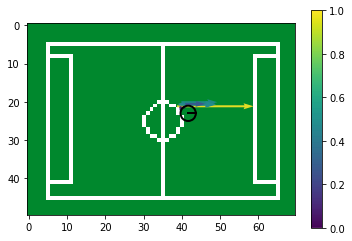

0 79 angle_map y, x
0.048857838 angle map weight
0 79 angle_map y, x
0.048857838 angle map weight
0 79 angle_map y, x
0.048857838 angle map weight
0 79 angle_map y, x
0.048857838 angle map weight
0 79 angle_map y, x
0.048857838 angle map weight
0 79 angle_map y, x
0.048857838 angle map weight
0 79 angle_map y, x
0.048857838 angle map weight
0 79 angle_map y, x
0.048857838 angle map weight
0 79 angle_map y, x
0.048857838 angle map weight
0 79 angle_map y, x
0.048857838 angle map weight


<Figure size 432x288 with 0 Axes>

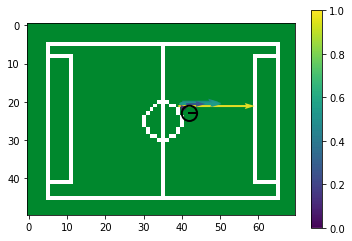

0 79 angle_map y, x
0.11521754 angle map weight
0 79 angle_map y, x
0.11521754 angle map weight
0 79 angle_map y, x
0.11521754 angle map weight
0 79 angle_map y, x
0.11521754 angle map weight
0 79 angle_map y, x
0.11521754 angle map weight
0 79 angle_map y, x
0.11521754 angle map weight
0 79 angle_map y, x
0.11521754 angle map weight
0 79 angle_map y, x
0.11521754 angle map weight
0 79 angle_map y, x
0.11521754 angle map weight
0 79 angle_map y, x
0.11521754 angle map weight


<Figure size 432x288 with 0 Axes>

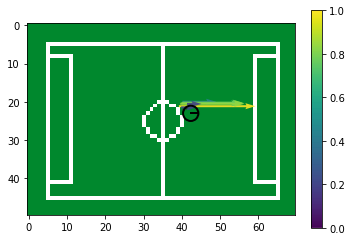

0 79 angle_map y, x
0.022212327 angle map weight
0 79 angle_map y, x
0.022212327 angle map weight
0 79 angle_map y, x
0.022212327 angle map weight
0 79 angle_map y, x
0.022212327 angle map weight
0 79 angle_map y, x
0.022212327 angle map weight
0 79 angle_map y, x
0.022212327 angle map weight
0 79 angle_map y, x
0.022212327 angle map weight
0 79 angle_map y, x
0.022212327 angle map weight
0 79 angle_map y, x
0.022212327 angle map weight
0 79 angle_map y, x
0.022212327 angle map weight


<Figure size 432x288 with 0 Axes>

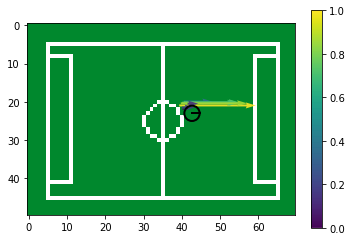

0 79 angle_map y, x
0.56038344 angle map weight
0 79 angle_map y, x
0.56038344 angle map weight
0 79 angle_map y, x
0.56038344 angle map weight
0 79 angle_map y, x
0.56038344 angle map weight
0 79 angle_map y, x
0.56038344 angle map weight
0 79 angle_map y, x
0.56038344 angle map weight
0 79 angle_map y, x
0.56038344 angle map weight
0 79 angle_map y, x
0.56038344 angle map weight
0 79 angle_map y, x
0.56038344 angle map weight
0 79 angle_map y, x
0.56038344 angle map weight


<Figure size 432x288 with 0 Axes>

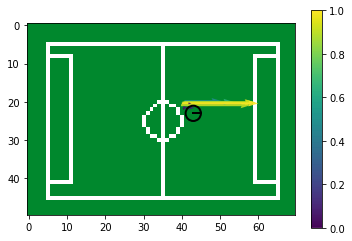

0 79 angle_map y, x
0.20274428 angle map weight
0 79 angle_map y, x
0.20274428 angle map weight
0 79 angle_map y, x
0.20274428 angle map weight
0 79 angle_map y, x
0.20274428 angle map weight
0 79 angle_map y, x
0.20274428 angle map weight
0 79 angle_map y, x
0.20274428 angle map weight
0 79 angle_map y, x
0.20274428 angle map weight
0 79 angle_map y, x
0.20274428 angle map weight
0 79 angle_map y, x
0.20274428 angle map weight
0 79 angle_map y, x
0.20274428 angle map weight


<Figure size 432x288 with 0 Axes>

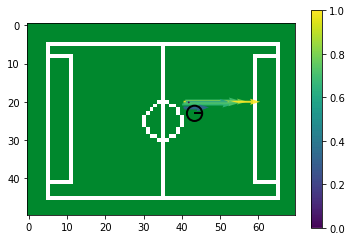

0 79 angle_map y, x
0.26487064 angle map weight
0 79 angle_map y, x
0.26487064 angle map weight
0 79 angle_map y, x
0.26487064 angle map weight
0 79 angle_map y, x
0.26487064 angle map weight
0 79 angle_map y, x
0.26487064 angle map weight
0 79 angle_map y, x
0.26487064 angle map weight
0 79 angle_map y, x
0.26487064 angle map weight
0 79 angle_map y, x
0.26487064 angle map weight
0 79 angle_map y, x
0.26487064 angle map weight
0 79 angle_map y, x
0.26487064 angle map weight


<Figure size 432x288 with 0 Axes>

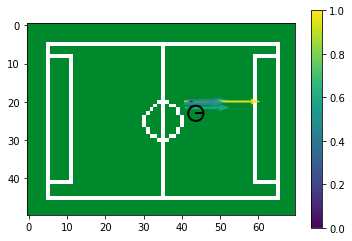

0 79 angle_map y, x
0.3065883 angle map weight
0 79 angle_map y, x
0.3065883 angle map weight
0 79 angle_map y, x
0.3065883 angle map weight
0 79 angle_map y, x
0.3065883 angle map weight
0 79 angle_map y, x
0.3065883 angle map weight
0 79 angle_map y, x
0.3065883 angle map weight
0 79 angle_map y, x
0.3065883 angle map weight
0 79 angle_map y, x
0.3065883 angle map weight
0 79 angle_map y, x
0.3065883 angle map weight
0 79 angle_map y, x
0.3065883 angle map weight


<Figure size 432x288 with 0 Axes>

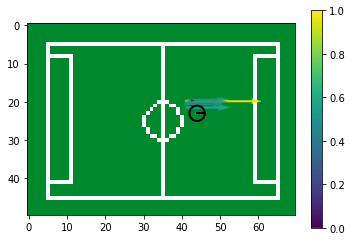

0 79 angle_map y, x
0.2135877 angle map weight
0 79 angle_map y, x
0.2135877 angle map weight
0 79 angle_map y, x
0.2135877 angle map weight
0 79 angle_map y, x
0.2135877 angle map weight
0 79 angle_map y, x
0.2135877 angle map weight
0 79 angle_map y, x
0.2135877 angle map weight
0 79 angle_map y, x
0.2135877 angle map weight
0 79 angle_map y, x
0.2135877 angle map weight
0 79 angle_map y, x
0.2135877 angle map weight
0 79 angle_map y, x
0.2135877 angle map weight


<Figure size 432x288 with 0 Axes>

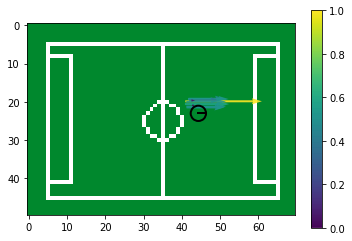

0 79 angle_map y, x
0.5569309 angle map weight
0 79 angle_map y, x
0.5569309 angle map weight
0 79 angle_map y, x
0.5569309 angle map weight
0 79 angle_map y, x
0.5569309 angle map weight
0 79 angle_map y, x
0.5569309 angle map weight
0 79 angle_map y, x
0.5569309 angle map weight
0 79 angle_map y, x
0.5569309 angle map weight
0 79 angle_map y, x
0.5569309 angle map weight
0 79 angle_map y, x
0.5569309 angle map weight
0 79 angle_map y, x
0.5569309 angle map weight


<Figure size 432x288 with 0 Axes>

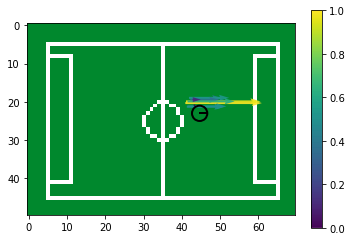

0 79 angle_map y, x
0.9088476 angle map weight
0 79 angle_map y, x
0.9088476 angle map weight
0 79 angle_map y, x
0.9088476 angle map weight
0 79 angle_map y, x
0.9088476 angle map weight
0 79 angle_map y, x
0.9088476 angle map weight
0 79 angle_map y, x
0.9088476 angle map weight
0 79 angle_map y, x
0.9088476 angle map weight
0 79 angle_map y, x
0.9088476 angle map weight
0 79 angle_map y, x
0.9088476 angle map weight
0 79 angle_map y, x
0.9088476 angle map weight


<Figure size 432x288 with 0 Axes>

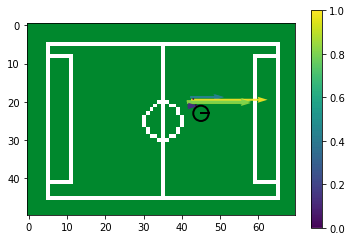

0 79 angle_map y, x
0.8578682 angle map weight
0 79 angle_map y, x
0.8578682 angle map weight
0 79 angle_map y, x
0.8578682 angle map weight
0 79 angle_map y, x
0.8578682 angle map weight
0 79 angle_map y, x
0.8578682 angle map weight
0 79 angle_map y, x
0.8578682 angle map weight
0 79 angle_map y, x
0.8578682 angle map weight
0 79 angle_map y, x
0.8578682 angle map weight
0 79 angle_map y, x
0.8578682 angle map weight
0 79 angle_map y, x
0.8578682 angle map weight


<Figure size 432x288 with 0 Axes>

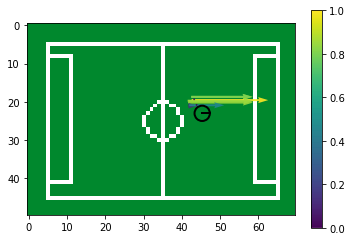

0 79 angle_map y, x
0.6986397 angle map weight
0 79 angle_map y, x
0.6986397 angle map weight
0 79 angle_map y, x
0.6986397 angle map weight
0 79 angle_map y, x
0.6986397 angle map weight
0 79 angle_map y, x
0.6986397 angle map weight
0 79 angle_map y, x
0.6986397 angle map weight
0 79 angle_map y, x
0.6986397 angle map weight
0 79 angle_map y, x
0.6986397 angle map weight
0 79 angle_map y, x
0.6986397 angle map weight
0 79 angle_map y, x
0.6986397 angle map weight


<Figure size 432x288 with 0 Axes>

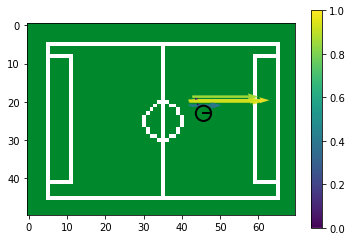

0 79 angle_map y, x
0.9266101 angle map weight
0 79 angle_map y, x
0.9266101 angle map weight
0 79 angle_map y, x
0.9266101 angle map weight
0 79 angle_map y, x
0.9266101 angle map weight
0 79 angle_map y, x
0.9266101 angle map weight
0 79 angle_map y, x
0.9266101 angle map weight
0 79 angle_map y, x
0.9266101 angle map weight
0 79 angle_map y, x
0.9266101 angle map weight
0 79 angle_map y, x
0.9266101 angle map weight
0 79 angle_map y, x
0.9266101 angle map weight


<Figure size 432x288 with 0 Axes>

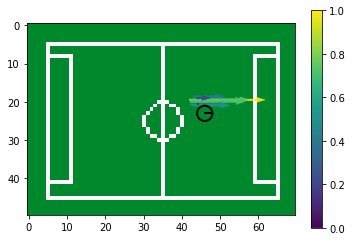

0 79 angle_map y, x
0.6753969 angle map weight
0 79 angle_map y, x
0.6753969 angle map weight
0 79 angle_map y, x
0.6753969 angle map weight
0 79 angle_map y, x
0.6753969 angle map weight
0 79 angle_map y, x
0.6753969 angle map weight
0 79 angle_map y, x
0.6753969 angle map weight
0 79 angle_map y, x
0.6753969 angle map weight
0 79 angle_map y, x
0.6753969 angle map weight
0 79 angle_map y, x
0.6753969 angle map weight
0 79 angle_map y, x
0.6753969 angle map weight


<Figure size 432x288 with 0 Axes>

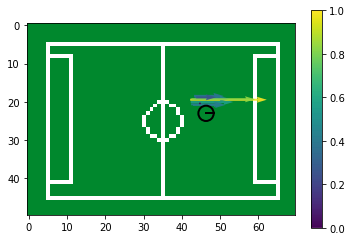

0 79 angle_map y, x
0.5928334 angle map weight
0 79 angle_map y, x
0.5928334 angle map weight
0 79 angle_map y, x
0.5928334 angle map weight
0 79 angle_map y, x
0.5928334 angle map weight
0 79 angle_map y, x
0.5928334 angle map weight
0 79 angle_map y, x
0.5928334 angle map weight
0 79 angle_map y, x
0.5928334 angle map weight
0 79 angle_map y, x
0.5928334 angle map weight
0 79 angle_map y, x
0.5928334 angle map weight
0 79 angle_map y, x
0.5928334 angle map weight


<Figure size 432x288 with 0 Axes>

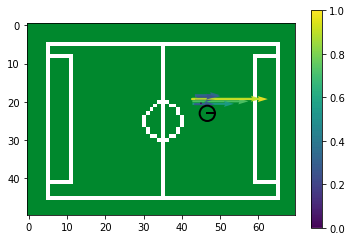

0 79 angle_map y, x
0.20325172 angle map weight
0 79 angle_map y, x
0.20325172 angle map weight
0 79 angle_map y, x
0.20325172 angle map weight
0 79 angle_map y, x
0.20325172 angle map weight
0 79 angle_map y, x
0.20325172 angle map weight
0 79 angle_map y, x
0.20325172 angle map weight
0 79 angle_map y, x
0.20325172 angle map weight
0 79 angle_map y, x
0.20325172 angle map weight
0 79 angle_map y, x
0.20325172 angle map weight
0 79 angle_map y, x
0.20325172 angle map weight


<Figure size 432x288 with 0 Axes>

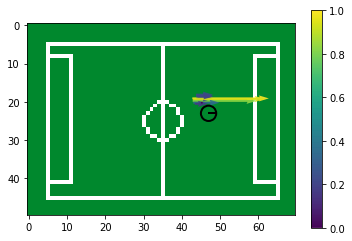

0 79 angle_map y, x
0.71052647 angle map weight
0 79 angle_map y, x
0.71052647 angle map weight
0 79 angle_map y, x
0.71052647 angle map weight
0 79 angle_map y, x
0.71052647 angle map weight
0 79 angle_map y, x
0.71052647 angle map weight
0 79 angle_map y, x
0.71052647 angle map weight
0 79 angle_map y, x
0.71052647 angle map weight
0 79 angle_map y, x
0.71052647 angle map weight
0 79 angle_map y, x
0.71052647 angle map weight
0 79 angle_map y, x
0.71052647 angle map weight


<Figure size 432x288 with 0 Axes>

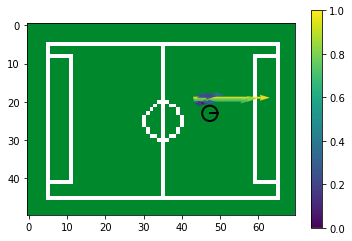

0 79 angle_map y, x
0.46658215 angle map weight
0 79 angle_map y, x
0.46658215 angle map weight
0 79 angle_map y, x
0.46658215 angle map weight
0 79 angle_map y, x
0.46658215 angle map weight
0 79 angle_map y, x
0.46658215 angle map weight
0 79 angle_map y, x
0.46658215 angle map weight
0 79 angle_map y, x
0.46658215 angle map weight
0 79 angle_map y, x
0.46658215 angle map weight
0 79 angle_map y, x
0.46658215 angle map weight
0 79 angle_map y, x
0.46658215 angle map weight


<Figure size 432x288 with 0 Axes>

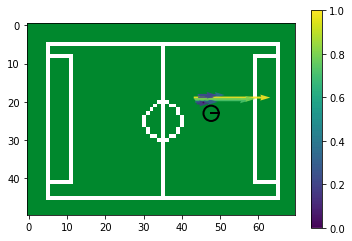

0 79 angle_map y, x
0.0057964623 angle map weight
0 79 angle_map y, x
0.0057964623 angle map weight
0 79 angle_map y, x
0.0057964623 angle map weight
0 79 angle_map y, x
0.0057964623 angle map weight
0 79 angle_map y, x
0.0057964623 angle map weight
0 79 angle_map y, x
0.0057964623 angle map weight
0 79 angle_map y, x
0.0057964623 angle map weight
0 79 angle_map y, x
0.0057964623 angle map weight
0 79 angle_map y, x
0.0057964623 angle map weight
0 79 angle_map y, x
0.0057964623 angle map weight


<Figure size 432x288 with 0 Axes>

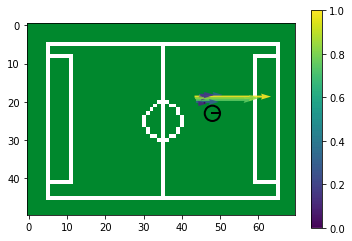

0 79 angle_map y, x
0.0137133 angle map weight
0 79 angle_map y, x
0.0137133 angle map weight
0 79 angle_map y, x
0.0137133 angle map weight
0 79 angle_map y, x
0.0137133 angle map weight
0 79 angle_map y, x
0.0137133 angle map weight
0 79 angle_map y, x
0.0137133 angle map weight
0 79 angle_map y, x
0.0137133 angle map weight
0 79 angle_map y, x
0.0137133 angle map weight
0 79 angle_map y, x
0.0137133 angle map weight
0 79 angle_map y, x
0.0137133 angle map weight


<Figure size 432x288 with 0 Axes>

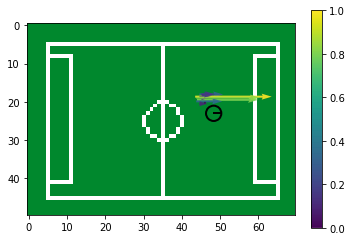

0 79 angle_map y, x
0.012029678 angle map weight
0 79 angle_map y, x
0.012029678 angle map weight
0 79 angle_map y, x
0.012029678 angle map weight
0 79 angle_map y, x
0.012029678 angle map weight
0 79 angle_map y, x
0.012029678 angle map weight
0 79 angle_map y, x
0.012029678 angle map weight
0 79 angle_map y, x
0.012029678 angle map weight
0 79 angle_map y, x
0.012029678 angle map weight
0 79 angle_map y, x
0.012029678 angle map weight
0 79 angle_map y, x
0.012029678 angle map weight


<Figure size 432x288 with 0 Axes>

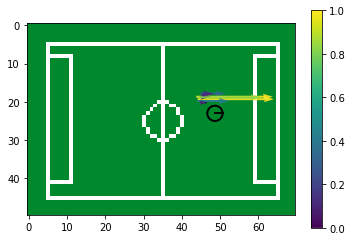

0 79 angle_map y, x
0.037242115 angle map weight
0 79 angle_map y, x
0.037242115 angle map weight
0 79 angle_map y, x
0.037242115 angle map weight
0 79 angle_map y, x
0.037242115 angle map weight
0 79 angle_map y, x
0.037242115 angle map weight
0 79 angle_map y, x
0.037242115 angle map weight
0 79 angle_map y, x
0.037242115 angle map weight
0 79 angle_map y, x
0.037242115 angle map weight
0 79 angle_map y, x
0.037242115 angle map weight
0 79 angle_map y, x
0.037242115 angle map weight


<Figure size 432x288 with 0 Axes>

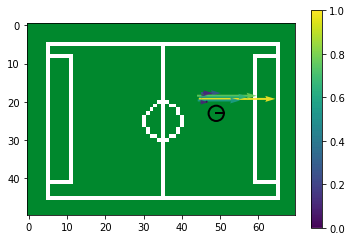

0 79 angle_map y, x
0.11240336 angle map weight
0 79 angle_map y, x
0.11240336 angle map weight
0 79 angle_map y, x
0.11240336 angle map weight
0 79 angle_map y, x
0.11240336 angle map weight
0 79 angle_map y, x
0.11240336 angle map weight
0 79 angle_map y, x
0.11240336 angle map weight
0 79 angle_map y, x
0.11240336 angle map weight
0 79 angle_map y, x
0.11240336 angle map weight
0 79 angle_map y, x
0.11240336 angle map weight
0 79 angle_map y, x
0.11240336 angle map weight


<Figure size 432x288 with 0 Axes>

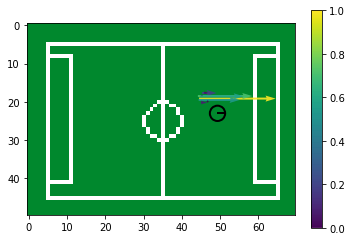

0 79 angle_map y, x
0.3504637 angle map weight
0 79 angle_map y, x
0.3504637 angle map weight
0 79 angle_map y, x
0.3504637 angle map weight
0 79 angle_map y, x
0.3504637 angle map weight
0 79 angle_map y, x
0.3504637 angle map weight
0 79 angle_map y, x
0.3504637 angle map weight
0 79 angle_map y, x
0.3504637 angle map weight
0 79 angle_map y, x
0.3504637 angle map weight
0 79 angle_map y, x
0.3504637 angle map weight
0 79 angle_map y, x
0.3504637 angle map weight


<Figure size 432x288 with 0 Axes>

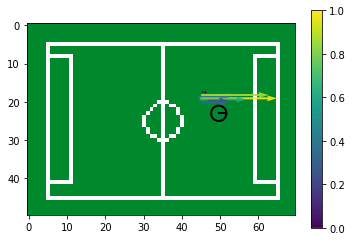

0 79 angle_map y, x
0.06120646 angle map weight
0 79 angle_map y, x
0.06120646 angle map weight
0 79 angle_map y, x
0.06120646 angle map weight
0 79 angle_map y, x
0.06120646 angle map weight
0 79 angle_map y, x
0.06120646 angle map weight
0 79 angle_map y, x
0.06120646 angle map weight
0 79 angle_map y, x
0.06120646 angle map weight
0 79 angle_map y, x
0.06120646 angle map weight
0 79 angle_map y, x
0.06120646 angle map weight
0 79 angle_map y, x
0.06120646 angle map weight


<Figure size 432x288 with 0 Axes>

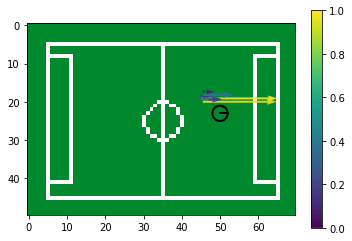

0 79 angle_map y, x
0.06624988 angle map weight
0 79 angle_map y, x
0.06624988 angle map weight
0 79 angle_map y, x
0.06624988 angle map weight
0 79 angle_map y, x
0.06624988 angle map weight
0 79 angle_map y, x
0.06624988 angle map weight
0 79 angle_map y, x
0.06624988 angle map weight
0 79 angle_map y, x
0.06624988 angle map weight
0 79 angle_map y, x
0.06624988 angle map weight
0 79 angle_map y, x
0.06624988 angle map weight
0 79 angle_map y, x
0.06624988 angle map weight


<Figure size 432x288 with 0 Axes>

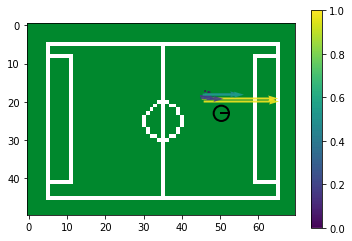

0 79 angle_map y, x
0.28683776 angle map weight
0 79 angle_map y, x
0.28683776 angle map weight
0 79 angle_map y, x
0.28683776 angle map weight
0 79 angle_map y, x
0.28683776 angle map weight
0 79 angle_map y, x
0.28683776 angle map weight
0 79 angle_map y, x
0.28683776 angle map weight
0 79 angle_map y, x
0.28683776 angle map weight
0 79 angle_map y, x
0.28683776 angle map weight
0 79 angle_map y, x
0.28683776 angle map weight
0 79 angle_map y, x
0.28683776 angle map weight


<Figure size 432x288 with 0 Axes>

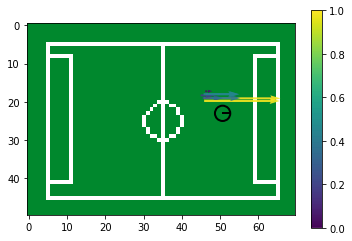

0 79 angle_map y, x
0.6377934 angle map weight
0 79 angle_map y, x
0.6377934 angle map weight
0 79 angle_map y, x
0.6377934 angle map weight
0 79 angle_map y, x
0.6377934 angle map weight
0 79 angle_map y, x
0.6377934 angle map weight
0 79 angle_map y, x
0.6377934 angle map weight
0 79 angle_map y, x
0.6377934 angle map weight
0 79 angle_map y, x
0.6377934 angle map weight
0 79 angle_map y, x
0.6377934 angle map weight
0 79 angle_map y, x
0.6377934 angle map weight


<Figure size 432x288 with 0 Axes>

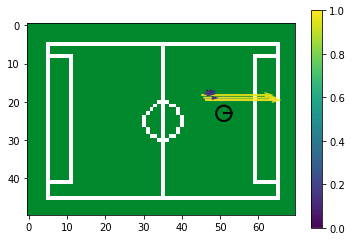

0 79 angle_map y, x
0.51707363 angle map weight
0 79 angle_map y, x
0.51707363 angle map weight
0 79 angle_map y, x
0.51707363 angle map weight
0 79 angle_map y, x
0.51707363 angle map weight
0 79 angle_map y, x
0.51707363 angle map weight
0 79 angle_map y, x
0.51707363 angle map weight
0 79 angle_map y, x
0.51707363 angle map weight
0 79 angle_map y, x
0.51707363 angle map weight
0 79 angle_map y, x
0.51707363 angle map weight
0 79 angle_map y, x
0.51707363 angle map weight


<Figure size 432x288 with 0 Axes>

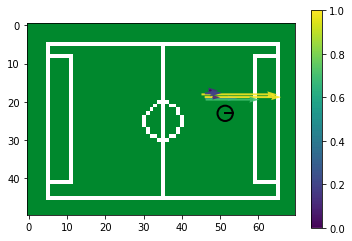

0 79 angle_map y, x
0.19036523 angle map weight
0 79 angle_map y, x
0.19036523 angle map weight
0 79 angle_map y, x
0.19036523 angle map weight
0 79 angle_map y, x
0.19036523 angle map weight
0 79 angle_map y, x
0.19036523 angle map weight
0 79 angle_map y, x
0.19036523 angle map weight
0 79 angle_map y, x
0.19036523 angle map weight
0 79 angle_map y, x
0.19036523 angle map weight
0 79 angle_map y, x
0.19036523 angle map weight
0 79 angle_map y, x
0.19036523 angle map weight


<Figure size 432x288 with 0 Axes>

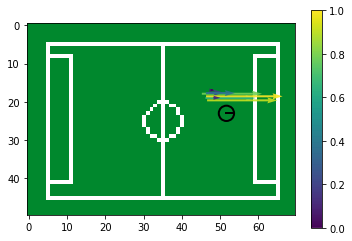

0 79 angle_map y, x
0.015102148 angle map weight
0 79 angle_map y, x
0.015102148 angle map weight
0 79 angle_map y, x
0.015102148 angle map weight
0 79 angle_map y, x
0.015102148 angle map weight
0 79 angle_map y, x
0.015102148 angle map weight
0 79 angle_map y, x
0.015102148 angle map weight
0 79 angle_map y, x
0.015102148 angle map weight
0 79 angle_map y, x
0.015102148 angle map weight
0 79 angle_map y, x
0.015102148 angle map weight
0 79 angle_map y, x
0.015102148 angle map weight


<Figure size 432x288 with 0 Axes>

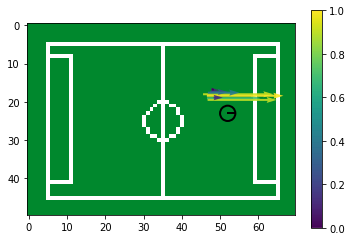

0 79 angle_map y, x
0.0027234852 angle map weight
0 79 angle_map y, x
0.0027234852 angle map weight
0 79 angle_map y, x
0.0027234852 angle map weight
0 79 angle_map y, x
0.0027234852 angle map weight
0 79 angle_map y, x
0.0027234852 angle map weight
0 79 angle_map y, x
0.0027234852 angle map weight
0 79 angle_map y, x
0.0027234852 angle map weight
0 79 angle_map y, x
0.0027234852 angle map weight
0 79 angle_map y, x
0.0027234852 angle map weight
0 79 angle_map y, x
0.0027234852 angle map weight


<Figure size 432x288 with 0 Axes>

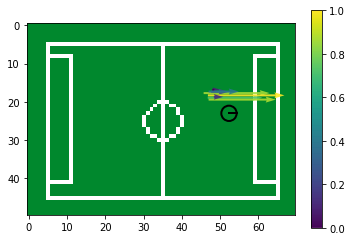

0 79 angle_map y, x
0.001349479 angle map weight
0 79 angle_map y, x
0.001349479 angle map weight
0 79 angle_map y, x
0.001349479 angle map weight
0 79 angle_map y, x
0.001349479 angle map weight
0 79 angle_map y, x
0.001349479 angle map weight
0 79 angle_map y, x
0.001349479 angle map weight
0 79 angle_map y, x
0.001349479 angle map weight
0 79 angle_map y, x
0.001349479 angle map weight
0 79 angle_map y, x
0.001349479 angle map weight
0 79 angle_map y, x
0.001349479 angle map weight


<Figure size 432x288 with 0 Axes>

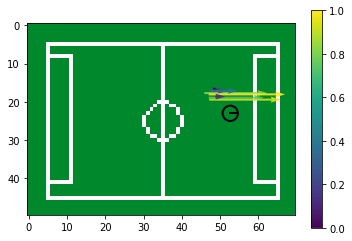

0 79 angle_map y, x
0.00082951784 angle map weight
0 79 angle_map y, x
0.00082951784 angle map weight
0 79 angle_map y, x
0.00082951784 angle map weight
0 79 angle_map y, x
0.00082951784 angle map weight
0 79 angle_map y, x
0.00082951784 angle map weight
0 79 angle_map y, x
0.00082951784 angle map weight
0 79 angle_map y, x
0.00082951784 angle map weight
0 79 angle_map y, x
0.00082951784 angle map weight
0 79 angle_map y, x
0.00082951784 angle map weight
0 79 angle_map y, x
0.00082951784 angle map weight


<Figure size 432x288 with 0 Axes>

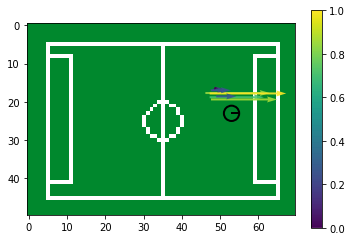

0 79 angle_map y, x
0.0039695203 angle map weight
0 79 angle_map y, x
0.0039695203 angle map weight
0 79 angle_map y, x
0.0039695203 angle map weight
0 79 angle_map y, x
0.0039695203 angle map weight
0 79 angle_map y, x
0.0039695203 angle map weight
0 79 angle_map y, x
0.0039695203 angle map weight
0 79 angle_map y, x
0.0039695203 angle map weight
0 79 angle_map y, x
0.0039695203 angle map weight
0 79 angle_map y, x
0.0039695203 angle map weight
0 79 angle_map y, x
0.0039695203 angle map weight


<Figure size 432x288 with 0 Axes>

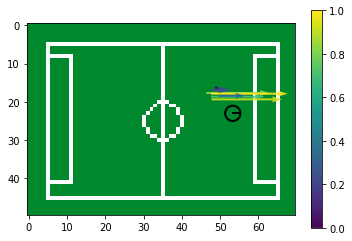

0 79 angle_map y, x
0.025690645 angle map weight
0 79 angle_map y, x
0.025690645 angle map weight
0 79 angle_map y, x
0.025690645 angle map weight
0 79 angle_map y, x
0.025690645 angle map weight
0 79 angle_map y, x
0.025690645 angle map weight
0 79 angle_map y, x
0.025690645 angle map weight
0 79 angle_map y, x
0.025690645 angle map weight
0 79 angle_map y, x
0.025690645 angle map weight
0 79 angle_map y, x
0.025690645 angle map weight
0 79 angle_map y, x
0.025690645 angle map weight


<Figure size 432x288 with 0 Axes>

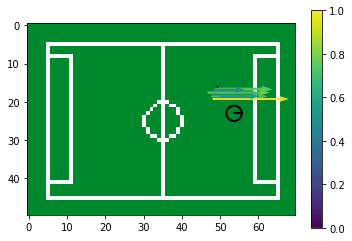

0 79 angle_map y, x
0.19077894 angle map weight
0 79 angle_map y, x
0.19077894 angle map weight
0 79 angle_map y, x
0.19077894 angle map weight
0 79 angle_map y, x
0.19077894 angle map weight
0 79 angle_map y, x
0.19077894 angle map weight
0 79 angle_map y, x
0.19077894 angle map weight
0 79 angle_map y, x
0.19077894 angle map weight
0 79 angle_map y, x
0.19077894 angle map weight
0 79 angle_map y, x
0.19077894 angle map weight
0 79 angle_map y, x
0.19077894 angle map weight


<Figure size 432x288 with 0 Axes>

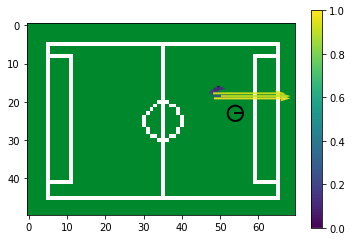

0 79 angle_map y, x
0.25819084 angle map weight
0 79 angle_map y, x
0.25819084 angle map weight
0 79 angle_map y, x
0.25819084 angle map weight
0 79 angle_map y, x
0.25819084 angle map weight
0 79 angle_map y, x
0.25819084 angle map weight
0 79 angle_map y, x
0.25819084 angle map weight
0 79 angle_map y, x
0.25819084 angle map weight
0 79 angle_map y, x
0.25819084 angle map weight
0 79 angle_map y, x
0.25819084 angle map weight
0 79 angle_map y, x
0.25819084 angle map weight


<Figure size 432x288 with 0 Axes>

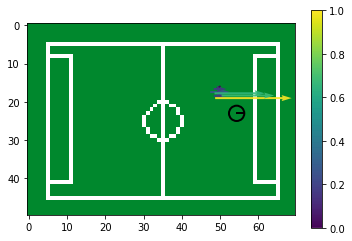

0 79 angle_map y, x
0.75527894 angle map weight
0 79 angle_map y, x
0.75527894 angle map weight
0 79 angle_map y, x
0.75527894 angle map weight
0 79 angle_map y, x
0.75527894 angle map weight
0 79 angle_map y, x
0.75527894 angle map weight
0 79 angle_map y, x
0.75527894 angle map weight
0 79 angle_map y, x
0.75527894 angle map weight
0 79 angle_map y, x
0.75527894 angle map weight
0 79 angle_map y, x
0.75527894 angle map weight
0 79 angle_map y, x
0.75527894 angle map weight


<Figure size 432x288 with 0 Axes>

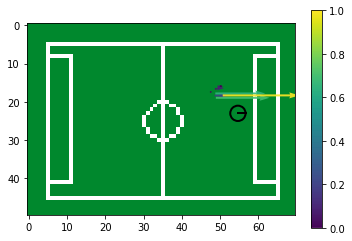

0 79 angle_map y, x
0.2801137 angle map weight
0 79 angle_map y, x
0.2801137 angle map weight
0 79 angle_map y, x
0.2801137 angle map weight
0 79 angle_map y, x
0.2801137 angle map weight
0 79 angle_map y, x
0.2801137 angle map weight
0 79 angle_map y, x
0.2801137 angle map weight
0 79 angle_map y, x
0.2801137 angle map weight
0 79 angle_map y, x
0.2801137 angle map weight
0 79 angle_map y, x
0.2801137 angle map weight
0 79 angle_map y, x
0.2801137 angle map weight


<Figure size 432x288 with 0 Axes>

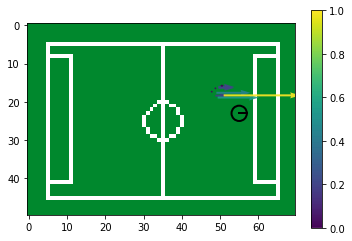

0 79 angle_map y, x
0.14333794 angle map weight
0 79 angle_map y, x
0.14333794 angle map weight
0 79 angle_map y, x
0.14333794 angle map weight
0 79 angle_map y, x
0.14333794 angle map weight
0 79 angle_map y, x
0.14333794 angle map weight
0 79 angle_map y, x
0.14333794 angle map weight
0 79 angle_map y, x
0.14333794 angle map weight
0 79 angle_map y, x
0.14333794 angle map weight
0 79 angle_map y, x
0.14333794 angle map weight
0 79 angle_map y, x
0.14333794 angle map weight


<Figure size 432x288 with 0 Axes>

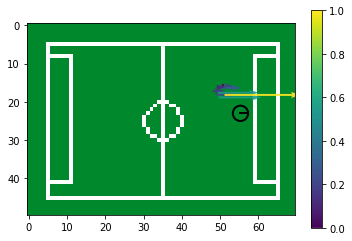

0 79 angle_map y, x
0.009527504 angle map weight
0 79 angle_map y, x
0.009527504 angle map weight
0 79 angle_map y, x
0.009527504 angle map weight
0 79 angle_map y, x
0.009527504 angle map weight
0 79 angle_map y, x
0.009527504 angle map weight
0 79 angle_map y, x
0.009527504 angle map weight
0 79 angle_map y, x
0.009527504 angle map weight
0 79 angle_map y, x
0.009527504 angle map weight
0 79 angle_map y, x
0.009527504 angle map weight
0 79 angle_map y, x
0.009527504 angle map weight


<Figure size 432x288 with 0 Axes>

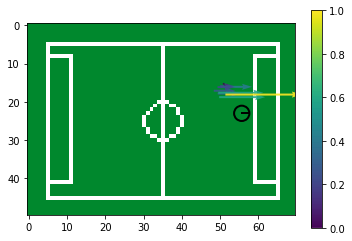

0 79 angle_map y, x
0.0015682876 angle map weight
0 79 angle_map y, x
0.0015682876 angle map weight
0 79 angle_map y, x
0.0015682876 angle map weight
0 79 angle_map y, x
0.0015682876 angle map weight
0 79 angle_map y, x
0.0015682876 angle map weight
0 79 angle_map y, x
0.0015682876 angle map weight
0 79 angle_map y, x
0.0015682876 angle map weight
0 79 angle_map y, x
0.0015682876 angle map weight
0 79 angle_map y, x
0.0015682876 angle map weight
0 79 angle_map y, x
0.0015682876 angle map weight


<Figure size 432x288 with 0 Axes>

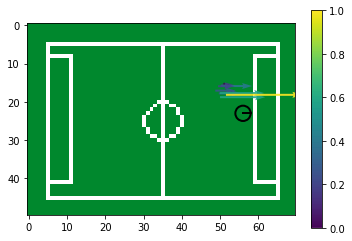

0 79 angle_map y, x
0.0074175 angle map weight
0 79 angle_map y, x
0.0074175 angle map weight
0 79 angle_map y, x
0.0074175 angle map weight
0 79 angle_map y, x
0.0074175 angle map weight
0 79 angle_map y, x
0.0074175 angle map weight
0 79 angle_map y, x
0.0074175 angle map weight
0 79 angle_map y, x
0.0074175 angle map weight
0 79 angle_map y, x
0.0074175 angle map weight
0 79 angle_map y, x
0.0074175 angle map weight
0 79 angle_map y, x
0.0074175 angle map weight


<Figure size 432x288 with 0 Axes>

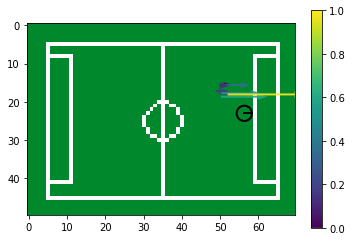

0 79 angle_map y, x
0.04512641 angle map weight
0 79 angle_map y, x
0.04512641 angle map weight
0 79 angle_map y, x
0.04512641 angle map weight
0 79 angle_map y, x
0.04512641 angle map weight
0 79 angle_map y, x
0.04512641 angle map weight
0 79 angle_map y, x
0.04512641 angle map weight
0 79 angle_map y, x
0.04512641 angle map weight
0 79 angle_map y, x
0.04512641 angle map weight
0 79 angle_map y, x
0.04512641 angle map weight
0 79 angle_map y, x
0.04512641 angle map weight


<Figure size 432x288 with 0 Axes>

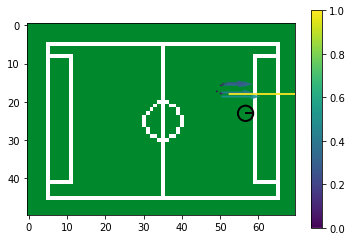

0 79 angle_map y, x
0.47368884 angle map weight
0 79 angle_map y, x
0.47368884 angle map weight
0 79 angle_map y, x
0.47368884 angle map weight
0 79 angle_map y, x
0.47368884 angle map weight
0 79 angle_map y, x
0.47368884 angle map weight
0 79 angle_map y, x
0.47368884 angle map weight
0 79 angle_map y, x
0.47368884 angle map weight
0 79 angle_map y, x
0.47368884 angle map weight
0 79 angle_map y, x
0.47368884 angle map weight
0 79 angle_map y, x
0.47368884 angle map weight


<Figure size 432x288 with 0 Axes>

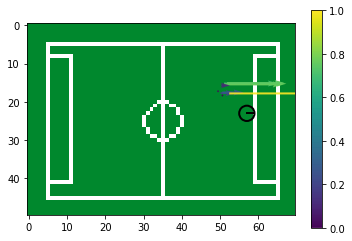

0 79 angle_map y, x
0.19056123 angle map weight
0 79 angle_map y, x
0.19056123 angle map weight
0 79 angle_map y, x
0.19056123 angle map weight
0 79 angle_map y, x
0.19056123 angle map weight
0 79 angle_map y, x
0.19056123 angle map weight
0 79 angle_map y, x
0.19056123 angle map weight
0 79 angle_map y, x
0.19056123 angle map weight
0 79 angle_map y, x
0.19056123 angle map weight
0 79 angle_map y, x
0.19056123 angle map weight
0 79 angle_map y, x
0.19056123 angle map weight


<Figure size 432x288 with 0 Axes>

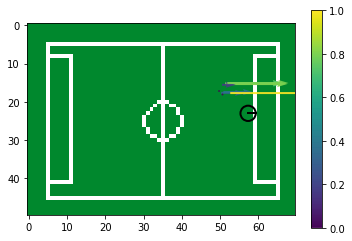

0 79 angle_map y, x
0.7730653 angle map weight
0 79 angle_map y, x
0.7730653 angle map weight
0 79 angle_map y, x
0.7730653 angle map weight
0 79 angle_map y, x
0.7730653 angle map weight
0 79 angle_map y, x
0.7730653 angle map weight
0 79 angle_map y, x
0.7730653 angle map weight
0 79 angle_map y, x
0.7730653 angle map weight
0 79 angle_map y, x
0.7730653 angle map weight
0 79 angle_map y, x
0.7730653 angle map weight
0 79 angle_map y, x
0.7730653 angle map weight


<Figure size 432x288 with 0 Axes>

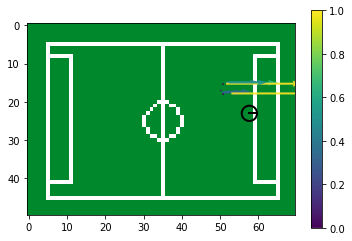

0 79 angle_map y, x
0.9342905 angle map weight
0 79 angle_map y, x
0.9342905 angle map weight
0 79 angle_map y, x
0.9342905 angle map weight
0 79 angle_map y, x
0.9342905 angle map weight
0 79 angle_map y, x
0.9342905 angle map weight
0 79 angle_map y, x
0.9342905 angle map weight
0 79 angle_map y, x
0.9342905 angle map weight
0 79 angle_map y, x
0.9342905 angle map weight
0 79 angle_map y, x
0.9342905 angle map weight
0 79 angle_map y, x
0.9342905 angle map weight


<Figure size 432x288 with 0 Axes>

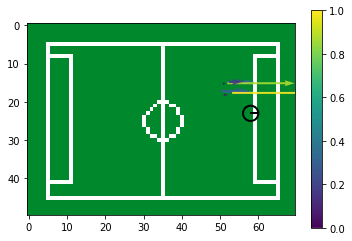

0 79 angle_map y, x
0.8581963 angle map weight
0 79 angle_map y, x
0.8581963 angle map weight
0 79 angle_map y, x
0.8581963 angle map weight
0 79 angle_map y, x
0.8581963 angle map weight
0 79 angle_map y, x
0.8581963 angle map weight
0 79 angle_map y, x
0.8581963 angle map weight
0 79 angle_map y, x
0.8581963 angle map weight
0 79 angle_map y, x
0.8581963 angle map weight
0 79 angle_map y, x
0.8581963 angle map weight
0 79 angle_map y, x
0.8581963 angle map weight


<Figure size 432x288 with 0 Axes>

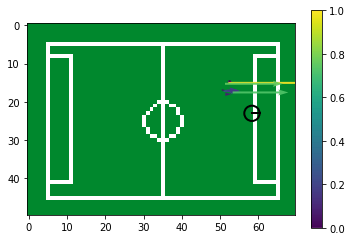

0 79 angle_map y, x
0.88417804 angle map weight
0 79 angle_map y, x
0.88417804 angle map weight
0 79 angle_map y, x
0.88417804 angle map weight
0 79 angle_map y, x
0.88417804 angle map weight
0 79 angle_map y, x
0.88417804 angle map weight
0 79 angle_map y, x
0.88417804 angle map weight
0 79 angle_map y, x
0.88417804 angle map weight
0 79 angle_map y, x
0.88417804 angle map weight
0 79 angle_map y, x
0.88417804 angle map weight
0 79 angle_map y, x
0.88417804 angle map weight


<Figure size 432x288 with 0 Axes>

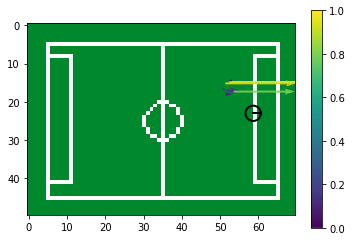

0 79 angle_map y, x
0.26457947 angle map weight
0 79 angle_map y, x
0.26457947 angle map weight
0 79 angle_map y, x
0.26457947 angle map weight
0 79 angle_map y, x
0.26457947 angle map weight
0 79 angle_map y, x
0.26457947 angle map weight
0 79 angle_map y, x
0.26457947 angle map weight
0 79 angle_map y, x
0.26457947 angle map weight
0 79 angle_map y, x
0.26457947 angle map weight
0 79 angle_map y, x
0.26457947 angle map weight
0 79 angle_map y, x
0.26457947 angle map weight


<Figure size 432x288 with 0 Axes>

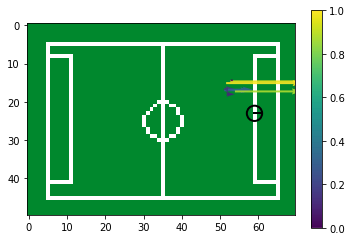

0 79 angle_map y, x
0.62109864 angle map weight
0 79 angle_map y, x
0.62109864 angle map weight
0 79 angle_map y, x
0.62109864 angle map weight
0 79 angle_map y, x
0.62109864 angle map weight
0 79 angle_map y, x
0.62109864 angle map weight
0 79 angle_map y, x
0.62109864 angle map weight
0 79 angle_map y, x
0.62109864 angle map weight
0 79 angle_map y, x
0.62109864 angle map weight
0 79 angle_map y, x
0.62109864 angle map weight
0 79 angle_map y, x
0.62109864 angle map weight


<Figure size 432x288 with 0 Axes>

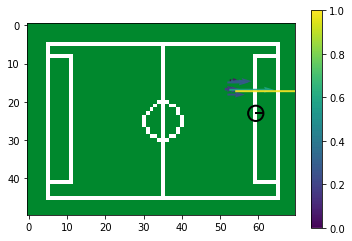

0 79 angle_map y, x
0.024286985 angle map weight
0 79 angle_map y, x
0.024286985 angle map weight
0 79 angle_map y, x
0.024286985 angle map weight
0 79 angle_map y, x
0.024286985 angle map weight
0 79 angle_map y, x
0.024286985 angle map weight
0 79 angle_map y, x
0.024286985 angle map weight
0 79 angle_map y, x
0.024286985 angle map weight
0 79 angle_map y, x
0.024286985 angle map weight
0 79 angle_map y, x
0.024286985 angle map weight
0 79 angle_map y, x
0.024286985 angle map weight


<Figure size 432x288 with 0 Axes>

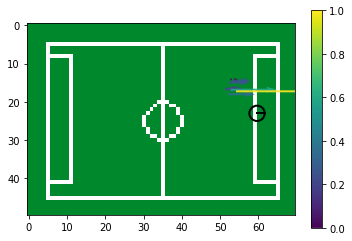

0 79 angle_map y, x
0.080979586 angle map weight
0 79 angle_map y, x
0.080979586 angle map weight
0 79 angle_map y, x
0.080979586 angle map weight
0 79 angle_map y, x
0.080979586 angle map weight
0 79 angle_map y, x
0.080979586 angle map weight
0 79 angle_map y, x
0.080979586 angle map weight
0 79 angle_map y, x
0.080979586 angle map weight
0 79 angle_map y, x
0.080979586 angle map weight
0 79 angle_map y, x
0.080979586 angle map weight
0 79 angle_map y, x
0.080979586 angle map weight


<Figure size 432x288 with 0 Axes>

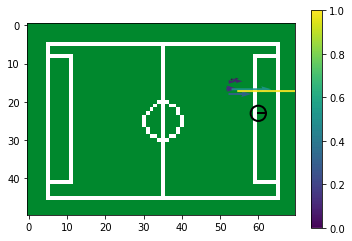

0 79 angle_map y, x
0.20631233 angle map weight
0 79 angle_map y, x
0.20631233 angle map weight
0 79 angle_map y, x
0.20631233 angle map weight
0 79 angle_map y, x
0.20631233 angle map weight
0 79 angle_map y, x
0.20631233 angle map weight
0 79 angle_map y, x
0.20631233 angle map weight
0 79 angle_map y, x
0.20631233 angle map weight
0 79 angle_map y, x
0.20631233 angle map weight
0 79 angle_map y, x
0.20631233 angle map weight
0 79 angle_map y, x
0.20631233 angle map weight


<Figure size 432x288 with 0 Axes>

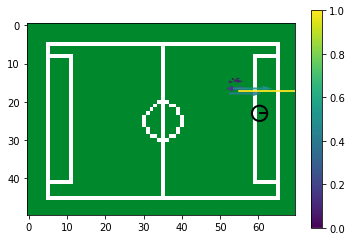

0 79 angle_map y, x
0.74950904 angle map weight
0 79 angle_map y, x
0.74950904 angle map weight
0 79 angle_map y, x
0.74950904 angle map weight
0 79 angle_map y, x
0.74950904 angle map weight
0 79 angle_map y, x
0.74950904 angle map weight
0 79 angle_map y, x
0.74950904 angle map weight
0 79 angle_map y, x
0.74950904 angle map weight
0 79 angle_map y, x
0.74950904 angle map weight
0 79 angle_map y, x
0.74950904 angle map weight
0 79 angle_map y, x
0.74950904 angle map weight


<Figure size 432x288 with 0 Axes>

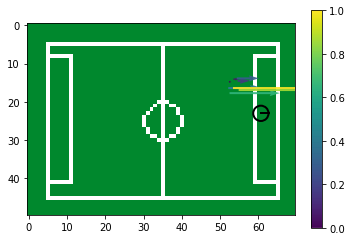

0 79 angle_map y, x
0.62608266 angle map weight
0 79 angle_map y, x
0.62608266 angle map weight
0 79 angle_map y, x
0.62608266 angle map weight
0 79 angle_map y, x
0.62608266 angle map weight
0 79 angle_map y, x
0.62608266 angle map weight
0 79 angle_map y, x
0.62608266 angle map weight
0 79 angle_map y, x
0.62608266 angle map weight
0 79 angle_map y, x
0.62608266 angle map weight
0 79 angle_map y, x
0.62608266 angle map weight
0 79 angle_map y, x
0.62608266 angle map weight


<Figure size 432x288 with 0 Axes>

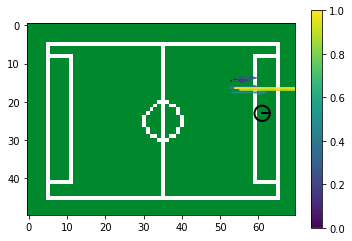

0 79 angle_map y, x
0.3553937 angle map weight
0 79 angle_map y, x
0.3553937 angle map weight
0 79 angle_map y, x
0.3553937 angle map weight
0 79 angle_map y, x
0.3553937 angle map weight
0 79 angle_map y, x
0.3553937 angle map weight
0 79 angle_map y, x
0.3553937 angle map weight
0 79 angle_map y, x
0.3553937 angle map weight
0 79 angle_map y, x
0.3553937 angle map weight
0 79 angle_map y, x
0.3553937 angle map weight
0 79 angle_map y, x
0.3553937 angle map weight


<Figure size 432x288 with 0 Axes>

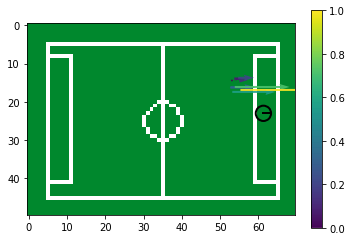

0 79 angle_map y, x
0.13415912 angle map weight
0 79 angle_map y, x
0.13415912 angle map weight
0 79 angle_map y, x
0.13415912 angle map weight
0 79 angle_map y, x
0.13415912 angle map weight
0 79 angle_map y, x
0.13415912 angle map weight
0 79 angle_map y, x
0.13415912 angle map weight
0 79 angle_map y, x
0.13415912 angle map weight
0 79 angle_map y, x
0.13415912 angle map weight
0 79 angle_map y, x
0.13415912 angle map weight
0 79 angle_map y, x
0.13415912 angle map weight


<Figure size 432x288 with 0 Axes>

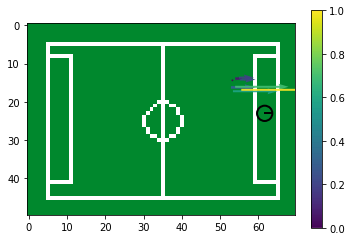

0 79 angle_map y, x
0.10183644 angle map weight
0 79 angle_map y, x
0.10183644 angle map weight
0 79 angle_map y, x
0.10183644 angle map weight
0 79 angle_map y, x
0.10183644 angle map weight
0 79 angle_map y, x
0.10183644 angle map weight
0 79 angle_map y, x
0.10183644 angle map weight
0 79 angle_map y, x
0.10183644 angle map weight
0 79 angle_map y, x
0.10183644 angle map weight
0 79 angle_map y, x
0.10183644 angle map weight
0 79 angle_map y, x
0.10183644 angle map weight


<Figure size 432x288 with 0 Axes>

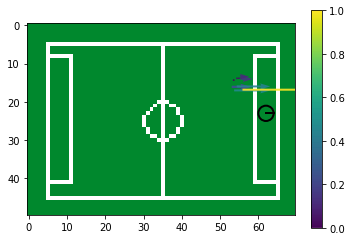

0 79 angle_map y, x
0.060498297 angle map weight
0 79 angle_map y, x
0.060498297 angle map weight
0 79 angle_map y, x
0.060498297 angle map weight
0 79 angle_map y, x
0.060498297 angle map weight
0 79 angle_map y, x
0.060498297 angle map weight
0 79 angle_map y, x
0.060498297 angle map weight
0 79 angle_map y, x
0.060498297 angle map weight
0 79 angle_map y, x
0.060498297 angle map weight
0 79 angle_map y, x
0.060498297 angle map weight
0 79 angle_map y, x
0.060498297 angle map weight


<Figure size 432x288 with 0 Axes>

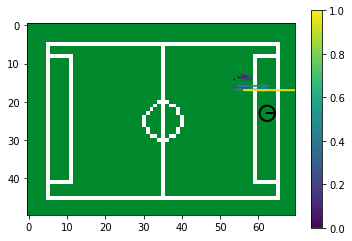

0 79 angle_map y, x
0.14321744 angle map weight
0 79 angle_map y, x
0.14321744 angle map weight
0 79 angle_map y, x
0.14321744 angle map weight
0 79 angle_map y, x
0.14321744 angle map weight
0 79 angle_map y, x
0.14321744 angle map weight
0 79 angle_map y, x
0.14321744 angle map weight
0 79 angle_map y, x
0.14321744 angle map weight
0 79 angle_map y, x
0.14321744 angle map weight
0 79 angle_map y, x
0.14321744 angle map weight
0 79 angle_map y, x
0.14321744 angle map weight


<Figure size 432x288 with 0 Axes>

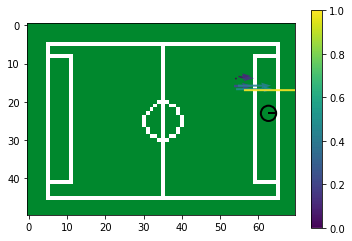

0 79 angle_map y, x
0.5524104 angle map weight
0 79 angle_map y, x
0.5524104 angle map weight
0 79 angle_map y, x
0.5524104 angle map weight
0 79 angle_map y, x
0.5524104 angle map weight
0 79 angle_map y, x
0.5524104 angle map weight
0 79 angle_map y, x
0.5524104 angle map weight
0 79 angle_map y, x
0.5524104 angle map weight
0 79 angle_map y, x
0.5524104 angle map weight
0 79 angle_map y, x
0.5524104 angle map weight
0 79 angle_map y, x
0.5524104 angle map weight


<Figure size 432x288 with 0 Axes>

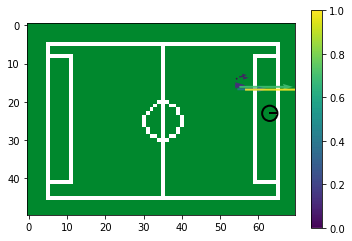

0 79 angle_map y, x
0.39546356 angle map weight
0 79 angle_map y, x
0.39546356 angle map weight
0 79 angle_map y, x
0.39546356 angle map weight
0 79 angle_map y, x
0.39546356 angle map weight
0 79 angle_map y, x
0.39546356 angle map weight
0 79 angle_map y, x
0.39546356 angle map weight
0 79 angle_map y, x
0.39546356 angle map weight
0 79 angle_map y, x
0.39546356 angle map weight
0 79 angle_map y, x
0.39546356 angle map weight
0 79 angle_map y, x
0.39546356 angle map weight


<Figure size 432x288 with 0 Axes>

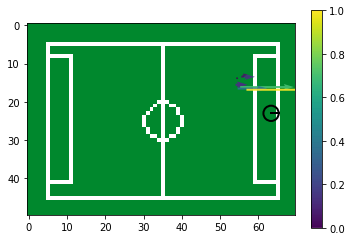

0 79 angle_map y, x
0.25023785 angle map weight
0 79 angle_map y, x
0.25023785 angle map weight
0 79 angle_map y, x
0.25023785 angle map weight
0 79 angle_map y, x
0.25023785 angle map weight
0 79 angle_map y, x
0.25023785 angle map weight
0 79 angle_map y, x
0.25023785 angle map weight
0 79 angle_map y, x
0.25023785 angle map weight
0 79 angle_map y, x
0.25023785 angle map weight
0 79 angle_map y, x
0.25023785 angle map weight
0 79 angle_map y, x
0.25023785 angle map weight


<Figure size 432x288 with 0 Axes>

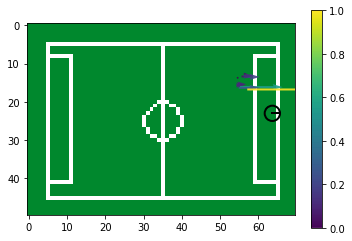

<Figure size 432x288 with 0 Axes>

In [17]:
image_name, x, y, th = read_csv('./continuous_data_center_circle_to_before_goal_log.csv')

dami = '../images/field.png'
tool = make_random_selfdata.MakeRandomSelfdata(dami)
plot_cls = Plot(tool)
p_num = 10
init_x, init_y = plot_cls.convertVrepPos2DisplayPosValue(x[0], y[0])
init_pose = [init_x, init_y, th[0]]
robot = Robot(init_pose[0],init_pose[1],init_pose[2])
cvae = CVAE()
particles = [Particle(init_pose, 1.0/p_num) for i in range(p_num)]
#print(particles[0].pose, particles[0].weight)
n = 0
#size = 20

d_kido = np.zeros((2,1), dtype =np.float32)
d_particle = np.zeros((2,1), dtype =np.float32)

for n in range(len(x)):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    d_p = np.empty((0,2), dtype=np.float32)
    if(n==0):
        cx, cy = plot_cls.convertVrepPos2DisplayPosValue(x[0], y[0])
        plot_cls.plotUpdate(cx, cy, th[n], particles, ax)
        plt.cla()
        plt.clf()
    else:
        #--------motion update----------#
        #robotのmotion_update
        cx, cy, cth = robot.motion_update(x[n], y[n], th[n])
        #particleのmotion_update
        for i in range(len(particles)):
            particles[i].pose = particles[i].motion_update(x[n], y[n], th[n], x[n-1], y[n-1], th[n-1])
        #--------observation update----------#
        cvae.pred_CVAE('./continuous_data_center_circle_to_before_goal/'+image_name[n])
        pos_map, angle_map = cvae.getMaps()
        #pos_map, angle_map = cvae.dammyGetMaps()
        d_kido = returnKidoAxisFropmPosMap(pos_map)
        for i in range(len(particles)):
            particles[i].observation_update(pos_map, angle_map)
            d_p = np.append(d_p, [[particles[i].pose[0],particles[i].pose[1]]], axis=0)
        #plt.scatter(d_p[:,0]+plot_cls.field_mergin, d_p[:,1]+plot_cls.field_mergin, color='red', marker='x')
        #plt.scatter(d_kido[:,0]+plot_cls.field_mergin, d_kido[:,1]+plot_cls.field_mergin, color='y', marker='o', s=6)
        #--------plot update----------#
        plot_cls.plotUpdate(cx,cy,cth, particles, ax)
        plt.cla()
        plt.clf()

#パーティクルを適当にまく
#モーションアップデートする（真値の1番目ー0番目）
#1番目の画像を使ってCVAEのゆうど関数から重みの更新
#これを繰り返す

[[1. 2.]
 [4. 5.]]
[49.89142187868467, 9.226414582656762]
[50.27320841808975, 9.750960051497122]
[50.096034197506356, 10.44741494937174]
[49.68185615136376, 9.477671017855124]
[50.71877883544509, 10.071617290225557]
[50.99794685434663, 8.273288282400786]
[50.343854983081265, 8.016286289952912]
[50.280329503051995, 8.629897566329305]
[50.27115010229241, 9.138367045588744]
[49.714646229379504, 8.593851298483782]


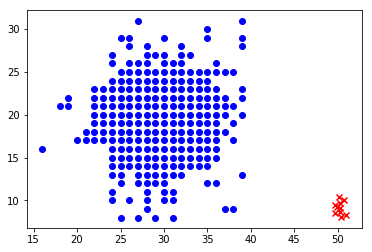

In [9]:
arr = np.empty((0,2), dtype=np.float32)
arr = np.append(arr, np.array([[1, 2]]), axis=0)
arr = np.append(arr, np.array([[4, 5]]), axis=0)
print(arr)
def returnKidoAxisFropmPosMap(pos_map):
    kido = np.empty((0,2), dtype=np.float32)
    for h in range(pos_map.shape[0]):
        for w in range(pos_map.shape[1]):
            if(pos_map[h, w] > 0):
                #print("!!!!!!!!!!!!")
                #kido = [w,h]
                kido = np.append(kido, np.array([[w,h]]), axis=0)
                #print(kido)
    #print(kido)
    return kido

d_p = np.empty((0,2), dtype=np.float32)
cvae.pred_CVAE('./continuous_data_center_circle_to_before_goal/'+image_name[1])
pos_map, angle_map = cvae.dammyGetMaps()
d_kido = returnKidoAxisFropmPosMap(pos_map)

for i in range(len(particles)):
    print([particles[i].pose[0],particles[i].pose[1]])
    #print(particles[i].pose[0][i])
    d_p = np.append(d_p, [[particles[i].pose[0],particles[i].pose[1]]], axis=0)
plt.scatter(d_p[:,0], d_p[:,1], color='red', marker='x')
plt.scatter(d_kido[:,0], d_kido[:,1], color='blue', marker='o')